# CF 예제 실습

In [1]:
import pandas as pd
import numpy as np
import hashlib
from tqdm import tqdm
from datasets import load_dataset
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# 영화 테이블 구성

data = {
    "영화 1": [4,5,None,2,4],
    "영화 2": [None,4,3,3,4],
    "영화 3": [5,None,4,5,4],
    "영화 4": [3,3,5,None,4],
    "영화 5": [4,3,4,2,None],
}

df = pd.DataFrame(data, index=["사용자 1", "사용자 2", "사용자 3", "사용자 4", "사용자 5"])

In [3]:
df

,영화 1,영화 2,영화 3,영화 4,영화 5
사용자 1,4.0,NaN,5.0,3.0,4.0
사용자 2,5.0,4.0,NaN,3.0,3.0
사용자 3,NaN,3.0,4.0,5.0,4.0
사용자 4,2.0,3.0,5.0,NaN,2.0
사용자 5,4.0,4.0,4.0,4.0,NaN


In [4]:
# 사용자 유사도 테이블 구성

user_df = df.copy()
user_df = user_df.fillna(0)
user_similarity = cosine_similarity(user_df, user_df)
user_similarity_df = pd.DataFrame(user_similarity, index=user_df.index, columns=user_df.index)
user_similarity_df

,사용자 1,사용자 2,사용자 3,사용자 4,사용자 5
사용자 1,1.000000,0.657031,0.772727,0.778731,0.738549
사용자 2,0.657031,1.000000,0.624981,0.562480,0.781133
사용자 3,0.772727,0.624981,1.000000,0.702757,0.738549
사용자 4,0.778731,0.562480,0.702757,1.000000,0.771517
사용자 5,0.738549,0.781133,0.738549,0.771517,1.000000


In [5]:
# 아이템 유사도 테이블 구성
item_df = np.transpose(df.copy())
item_df = item_df.fillna(0)
item_similarity = cosine_similarity(item_df, item_df)
item_similarity_df = pd.DataFrame(item_similarity, index=item_df.index, columns=item_df.index)
item_similarity_df

,영화 1,영화 2,영화 3,영화 4,영화 5
영화 1,1.000000,0.760500,0.650408,0.716766,0.668031
영화 2,0.760500,1.000000,0.671547,0.791694,0.632456
영화 3,0.650408,0.671547,1.000000,0.733225,0.757259
영화 4,0.716766,0.791694,0.733225,1.000000,0.795704
영화 5,0.668031,0.632456,0.757259,0.795704,1.000000


In [6]:
full_df = df.copy()
for user_id in full_df.index:
    for movie_id in full_df.columns:
        if not np.isnan(full_df[movie_id][user_id]): continue
        
        similarities = user_similarity_df[user_id].copy()
        movie_ratings = full_df[movie_id].copy()
        
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.dropna()
        similarities = similarities.drop(none_rating_idx)
        
        mean_rating = np.dot(similarities, movie_ratings) / similarities.sum()
        full_df[movie_id][user_id] = mean_rating
        
full_df
        
        

,영화 1,영화 2,영화 3,영화 4,영화 5
사용자 1,4.000000,3.473553,5.000000,3.000000,4.000000
사용자 2,5.000000,4.000000,4.464465,3.000000,3.000000
사용자 3,3.725069,3.000000,4.000000,5.000000,4.000000
사용자 4,2.000000,3.000000,5.000000,3.773235,2.000000
사용자 5,4.000000,4.000000,4.000000,4.000000,3.232884


In [7]:
watched_movies = ["영화 4", "영화 3"]
item_similarity_df[watched_movies[0]][~item_similarity_df.index.isin(watched_movies)].sort_values(ascending=False)[:3]

영화 5    0.795704
영화 2    0.791694
영화 1    0.716766
Name: 영화 4, dtype: float64

In [8]:
data = load_dataset("nbtpj/movielens-1m-ratings")["train"].shuffle(seed=10)
n_chunks = 10
chunk_size = len(data) // n_chunks
if len(data) % n_chunks != 0:
    chunk_size += 1

movielens_df = pd.DataFrame()

for start in tqdm(range(0, len(data), chunk_size)):
    end = start + chunk_size
    chunk_df = pd.DataFrame(data[start:end])
    movielens_df = pd.concat([movielens_df, chunk_df], ignore_index=True)
    
movielens_df = movielens_df[["user_id", "movie_id", "user_rating"]]


Found cached dataset parquet (/Users/jaypark/.cache/huggingface/datasets/nbtpj___parquet/nbtpj--movielens-1m-ratings-b1aa424c884e38a3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /Users/jaypark/.cache/huggingface/datasets/nbtpj___parquet/nbtpj--movielens-1m-ratings-b1aa424c884e38a3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-15aa091e090a52af.arrow
100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


In [9]:
movielens_df

,user_id,movie_id,user_rating
0,b'3032',b'782',5.0
1,b'5963',b'2716',4.0
2,b'2088',b'2019',5.0
3,b'2340',b'3253',5.0
4,b'3942',b'1200',4.0
...,...,...,...
1000204,b'4777',b'3461',4.0
1000205,b'2986',b'1345',4.0
1000206,b'854',b'3253',3.0
1000207,b'3462',b'2734',4.0


In [10]:
user_item_matrix = movielens_df.pivot_table(index="user_id", columns="movie_id", values="user_rating")
user_item_matrix

movie_id,b'1',b'10',b'100',b'1000',b'1002',b'1003',b'1004',b'1005',b'1006',b'1007',...,b'99',b'990',b'991',b'992',b'993',b'994',b'996',b'997',b'998',b'999'
user_id,,,,,,,,,,,,,,,,,,,,,
b'1',5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'10',5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'100',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'1000',5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'1001',4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'995',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'996',4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
b'997',4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
user_similarity = cosine_similarity(csr_matrix(user_item_matrix.fillna(0)))
user_similarity = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

def predict_rating(user_id: str, movie_id: str):
    movie_ratings = user_item_matrix[movie_id]
    user_similarities = user_similarity[user_id]
    valid_indices = movie_ratings.notna()
    movie_ratings = movie_ratings[valid_indices]
    user_similarities = user_similarities[valid_indices]
    if user_similarities.sum() > 0:
        return np.dot(user_similarities ,movie_ratings)/ user_similarities.sum()
    return movielens_df[movielens_df["movie_id"] == movie_id]["user_rating"].mean()

user_similarity


user_id,b'1',b'10',b'100',b'1000',b'1001',b'1002',b'1003',b'1004',b'1005',b'1006',...,b'990',b'991',b'992',b'993',b'994',b'995',b'996',b'997',b'998',b'999'
user_id,,,,,,,,,,,,,,,,,,,,,
b'1',1.000000,0.255288,0.123967,0.207800,0.139061,0.110320,0.121384,0.179143,0.103137,0.052816,...,0.079367,0.038048,0.032136,0.066641,0.070052,0.035731,0.170184,0.159267,0.119356,0.122059
b'10',0.255288,1.000000,0.258047,0.278753,0.154858,0.112222,0.141111,0.428224,0.188569,0.101856,...,0.153462,0.186086,0.083224,0.123288,0.117829,0.145650,0.300175,0.160346,0.132506,0.246251
b'100',0.123967,0.258047,1.000000,0.297539,0.075597,0.110450,0.358686,0.236065,0.171609,0.099147,...,0.098235,0.097953,0.065152,0.176048,0.271311,0.033754,0.344290,0.204302,0.113522,0.306104
b'1000',0.207800,0.278753,0.297539,1.000000,0.094710,0.047677,0.201722,0.353782,0.323584,0.130702,...,0.170100,0.076779,0.000000,0.197410,0.380741,0.044404,0.330748,0.172803,0.098456,0.245292
b'1001',0.139061,0.154858,0.075597,0.094710,1.000000,0.164551,0.053788,0.149019,0.137336,0.134462,...,0.146001,0.026842,0.096832,0.117641,0.092065,0.109499,0.221710,0.100597,0.269456,0.175194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'995',0.035731,0.145650,0.033754,0.044404,0.109499,0.072578,0.031406,0.088304,0.061001,0.032265,...,0.080559,0.252222,0.074207,0.097260,0.048650,1.000000,0.063925,0.019459,0.075830,0.052428
b'996',0.170184,0.300175,0.344290,0.330748,0.221710,0.224779,0.185226,0.349899,0.285861,0.164045,...,0.205186,0.086546,0.062523,0.183712,0.217672,0.063925,1.000000,0.174127,0.178834,0.417330
b'997',0.159267,0.160346,0.204302,0.172803,0.100597,0.068980,0.170771,0.171951,0.105527,0.049536,...,0.187734,0.030588,0.081380,0.160234,0.110656,0.019459,0.174127,1.000000,0.186575,0.182452


100%|██████████| 20005/20005 [00:03<00:00, 5258.49it/s]


Accuracy: 0.39


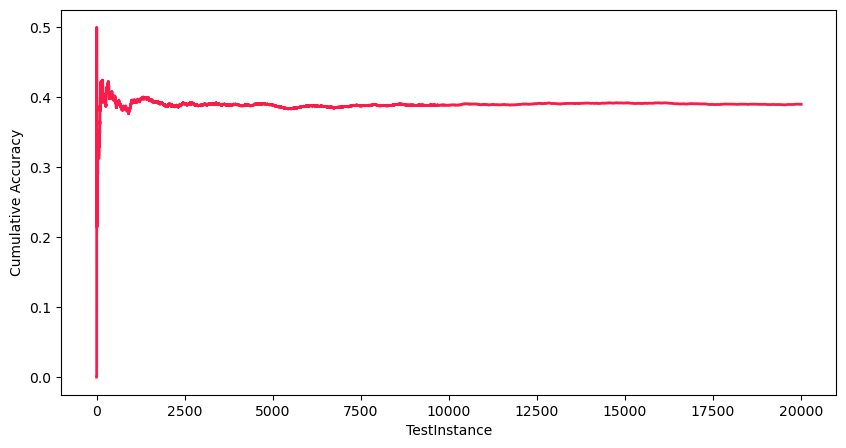

In [13]:
train_data, test_data = train_test_split(movielens_df, test_size=0.02, random_state=10)

predictions: list[float] = []
true_ratings: list[float] = []

for idx, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
    prediction = predict_rating(row["user_id"], row["movie_id"])
    predictions.append(prediction)
    true_ratings.append(row["user_rating"])
    
rounded_predictions = [round(pred) for pred in predictions]
accuracy = accuracy_score(true_ratings, rounded_predictions)
print(f"Accuracy: {accuracy:.2f}")

cumulative_accuracy = np.cumsum(np.array(rounded_predictions) == np.array(true_ratings)) / (np.arange(len(test_data)) + 1)

plt.figure(figsize=(10, 5))
plt.plot([i for i in range(len(test_data))], cumulative_accuracy, linewidth=2, color="#fc1c49")
plt.xlabel("TestInstance")
plt.ylabel("Cumulative Accuracy")
plt.show()